To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Read our **[Qwen3 Guide](https://docs.unsloth.ai/basics/qwen3-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit", # New Google 6 trillion tokens model 2.5x faster!
    "unsloth/gemma-2b-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.4.7: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.4.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the `ChatML` format for conversation style finetunes. We use [Open Assistant conversations](https://huggingface.co/datasets/philschmid/guanaco-sharegpt-style) in ShareGPT style. ChatML renders multi turn conversations like below:

```
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What's the capital of France?<|im_end|>
<|im_start|>assistant
Paris.
```

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old` and our own optimized `unsloth` template.

Normally one has to train `<|im_start|>` and `<|im_end|>`. We instead map `<|im_end|>` to be the EOS token, and leave `<|im_start|>` as is. This requires no additional training of additional tokens.

Note ShareGPT uses `{"from": "human", "value" : "Hi"}` and not `{"role": "user", "content" : "Hi"}`, so we use `mapping` to map it.

For text completions like novel writing, try this [notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Mistral_(7B)-Text_Completion.ipynb).

In [4]:
from unsloth.chat_templates import get_chat_template
from datasets import load_dataset

# ست کردن قالب چت
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml",  # پشتیبانی‌شده توسط unsloth
    mapping = {"role": "from", "content": "value", "user": "human", "assistant": "gpt"},
    map_eos_token = True,
)

# ساخت فرمت چت برای هر مثال در دیتاست
def formatting_prompts_func(examples):
    texts = []
    for instr, inp, out in zip(examples["instruction"], examples["input"], examples["output"]):
        # اگر input وجود دارد، آن را به instruction اضافه کن
        full_prompt = instr if inp.strip() == "" else f"{instr}\n{inp}"

        convo = [
            {"from": "human", "value": full_prompt},
            {"from": "gpt", "value": out}
        ]
        text = tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False)
        texts.append(text)
    return {"text": texts}

# لود دیتاست roshd
dataset = load_dataset("vahidhoseini/roshd", split="train")

# اعمال قالب
dataset = dataset.map(formatting_prompts_func, batched=True)


Unsloth: Will map <|im_end|> to EOS = </s>.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


README.md:   0%|          | 0.00/343 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/249 [00:00<?, ? examples/s]

Map:   0%|          | 0/249 [00:00<?, ? examples/s]

#60% of data

In [3]:
from unsloth.chat_templates import get_chat_template
from datasets import load_dataset

# ست کردن قالب چت
tokenizer = get_chat_template(
    tokenizer,
    chat_template="chatml",  # پشتیبانی‌شده توسط unsloth
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt"},
    map_eos_token=True,
)

# ساخت فرمت چت برای هر مثال در دیتاست
def formatting_prompts_func(examples):
    texts = []
    for instr, inp, out in zip(examples["instruction"], examples["input"], examples["output"]):
        # اگر input وجود دارد، آن را به instruction اضافه کن
        full_prompt = instr if inp.strip() == "" else f"{instr}\n{inp}"
        convo = [
            {"from": "human", "value": full_prompt},
            {"from": "gpt", "value": out}
        ]
        text = tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False)
        texts.append(text)
    return {"text": texts}

# لود دیتاست roshd
dataset = load_dataset("vahidhoseini/persian-Negotiations", split="train")

# جدا کردن فقط 30٪ از دیتاست
dataset = dataset.train_test_split(test_size=0.4, seed=42)["train"]  # فقط 30٪ نگه داشته می‌شود

# اعمال فرمت قالب چت
dataset = dataset.map(formatting_prompts_func, batched=True)


Unsloth: Will map <|im_end|> to EOS = </s>.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


Map:   0%|          | 0/20863 [00:00<?, ? examples/s]

Let's see how the `ChatML` format works by printing the 5th element

In [5]:
print("Instruction:", dataset[5]["instruction"])
print("Output:", dataset[5]["output"])


Instruction: بله همینطور هست 
Output: در خدمتتون هستیم 


In [6]:
print(dataset[5]["text"])

<|im_start|>user
بله همینطور هست <|im_end|>
<|im_start|>assistant
در خدمتتون هستیم <|im_end|>



If you're looking to make your own chat template, that also is possible! You must use the Jinja templating regime. We provide our own stripped down version of the `Unsloth template` which we find to be more efficient, and leverages ChatML, Zephyr and Alpaca styles.

More info on chat templates on [our wiki page!](https://github.com/unslothai/unsloth/wiki#chat-templates)

In [7]:
from unsloth.chat_templates import get_chat_template

# قالب تعریف‌شده با ساختار خاص unsloth
unsloth_template = \
    "{{ bos_token }}"\
    "{{ 'You are a helpful assistant to the user\n' }}"\
    "{% for message in messages %}"\
        "{% if message['role'] == 'user' %}"\
            "{{ '>>> User: ' + message['content'] + '\n' }}"\
        "{% elif message['role'] == 'assistant' %}"\
            "{{ '>>> Assistant: ' + message['content'] + eos_token + '\n' }}"\
        "{% endif %}"\
    "{% endfor %}"\
    "{% if add_generation_prompt %}"\
        "{{ '>>> Assistant: ' }}"\
    "{% endif %}"

# ❗ eos_token باید از tokenizer گرفته بشه
unsloth_eos_token = tokenizer.eos_token

# ✅ اعمال قالب به tokenizer
tokenizer = get_chat_template(
    tokenizer,
    chat_template = (unsloth_template, unsloth_eos_token),
    mapping = {"role": "from", "content": "value", "user": "human", "assistant": "gpt"},
    map_eos_token = True,
)


In [8]:
print(dataset[0].keys())


dict_keys(['instruction', 'input', 'output', 'text'])


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [10]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/249 [00:00<?, ? examples/s]

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
7.0 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 249 | Num Epochs = 2 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/7,000,000,000 (0.60% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.547900
2,1.852600
3,1.599900
4,1.484700
5,1.172500
6,1.270600
7,1.152200
8,1.275100
9,1.152400
10,0.984900


,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.5479,3.949973,0.000000,0.032,1,NaN,NaN,NaN,NaN,NaN
1,1.8526,4.246708,0.000040,0.064,2,NaN,NaN,NaN,NaN,NaN
2,1.5999,4.239283,0.000080,0.096,3,NaN,NaN,NaN,NaN,NaN
3,1.4847,3.097874,0.000120,0.128,4,NaN,NaN,NaN,NaN,NaN
4,1.1725,NaN,0.000160,0.160,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
56,0.5990,1.255309,0.000018,1.800,57,NaN,NaN,NaN,NaN,NaN
57,0.4847,1.162866,0.000015,1.832,58,NaN,NaN,NaN,NaN,NaN
58,0.6104,1.111620,0.000011,1.864,59,NaN,NaN,NaN,NaN,NaN
59,0.5262,1.325604,0.000007,1.896,60,NaN,NaN,NaN,NaN,NaN


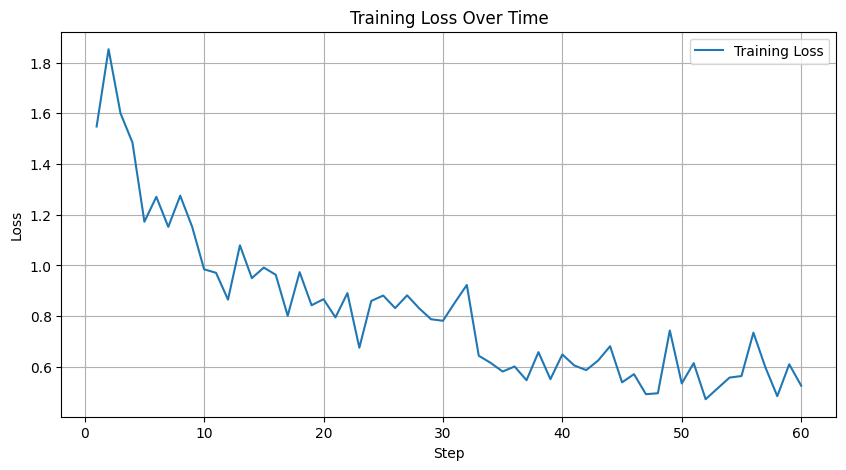

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# پس از آموزش
trainer_stats = trainer.train()

# استخراج لاگ‌های تاریخی
logs = trainer.state.log_history

# تبدیل به DataFrame برای راحتی
log_df = pd.DataFrame(logs)

# نمایش جدول لاگ‌ها (metrics مثل loss، eval_accuracy و ...)
display(log_df)

# رسم نمودار loss
if 'loss' in log_df.columns:
    plt.figure(figsize=(10,5))
    plt.plot(log_df["step"], log_df["loss"], label="Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# اگر accuracy در لاگ‌ها هست، رسم accuracy
if 'eval_accuracy' in log_df.columns:
    plt.figure(figsize=(10,5))
    plt.plot(log_df["step"], log_df["eval_accuracy"], label="Eval Accuracy", color="green")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

387.9294 seconds used for training.
6.47 minutes used for training.
Peak reserved memory = 7.0 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 47.487 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Inference"></a>
### Inference
Let's run the model! Since we're using `ChatML`, use `apply_chat_template` with `add_generation_prompt` set to `True` for inference.

In [15]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "برنامه نویسی بلدی؟"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|im_start|>user\nبرنامه نویسی بلدی؟<|im_end|>\n<|im_start|>assistant\nبلدی یک برنامه نویسی است که برای ایجاد و انتشار برنامه های برنام']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [15]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "سلام خوبی؟"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

<s>You are a helpful assistant to the user
>>> User: سلام خوبی؟
>>> Assistant: سلام وقت بخیر ، آیا شما ربات تلگرام دارید یا سایت وب با امکانات خاصی نیاز دارید؟<|im_end|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "What is a famous tall tower in Paris?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<|im_start|>user
What is a famous tall tower in Paris?<|im_end|> 
<|im_start|>assistant
The Eiffel Tower is a famous tall tower in Paris. It is one of the most recognizable landmarks in the world and is a popular tourist destination. The tower was built in 1889 for the World's Fair and is named after Gustave Eiffel, the engineer who designed and built it. The tower stands at a height of 324 meters (1,063 feet) and is made of iron. It is located on the Champ de Mars, a large public park in Paris.<|im_end|>


You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoModelForPeftCausalLM
    from transformers import AutoTokenizer

    model = AutoModelForPeftCausalLM.from_pretrained(
        "lora_model",  # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit=load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
